# Temporal Patterns and Seasonality

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import zscore
from datetime import datetime 
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter, MonthLocator

In [3]:
df_ev = pd.read_csv("data/cleaned_chargingdata.csv")
df_weather = pd.read_csv("data/cleaned_weather_data.csv")

In [4]:
df_ev['id'] = df_ev['id'].astype('string')

df_ev['connectionTime'] = pd.to_datetime(df_ev['connectionTime'], errors='coerce', utc=True)  
df_ev['disconnectTime'] = pd.to_datetime(df_ev['disconnectTime'], errors='coerce', utc=True)  
df_ev['doneChargingTime'] = pd.to_datetime(df_ev['doneChargingTime'], errors='coerce', utc=True) 

df_ev['connectionTime'] = df_ev['connectionTime'].dt.tz_convert('America/Los_Angeles')
df_ev['disconnectTime'] = df_ev['disconnectTime'].dt.tz_convert('America/Los_Angeles')
df_ev['doneChargingTime'] = df_ev['doneChargingTime'].dt.tz_convert('America/Los_Angeles')

# df_ev['connectionTime'] = df_ev['connectionTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)
# df_ev['disconnectTime'] = df_ev['disconnectTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)
# df_ev['doneChargingTime'] = df_ev['doneChargingTime'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)

# df_ev['sessionID'] = df_ev['sessionID'].astype('string')
df_ev['siteID'] = df_ev['siteID'].astype('string')
# df_ev['spaceID'] = df_ev['spaceID'].astype('string')
# df_ev['stationID'] = df_ev['stationID'].astype('string')
# df_ev['timezone'] = df_ev['timezone'].astype('string')
# df_ev['userID'] = df_ev['userID'].astype('string')

df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], utc=True)

In [6]:
max_time_weather = df_weather['timestamp'].max()
min_time_weather = df_weather['timestamp'].min()
max_time_charging = df_ev['connectionTime'].max()
min_time_charging = df_ev['connectionTime'].min()
print(max_time_weather,
      min_time_weather,
      max_time_charging,
      min_time_charging)

2021-01-01 07:53:00+00:00 2018-04-25 10:42:00+00:00 2021-09-13 22:43:39-07:00 2018-04-25 04:08:04-07:00


In [7]:
start_time = max_time_weather - pd.DateOffset(years=1)
end_time = max_time_charging - pd.DateOffset(years=1)
rows_to_duplicate = df_weather[(df_weather['timestamp'] >= start_time) &(df_weather['timestamp'] <= end_time)].copy()
rows_to_duplicate['timestamp'] = rows_to_duplicate['timestamp'] + pd.DateOffset(years=1)

In [8]:
df_weather = pd.concat([df_weather, rows_to_duplicate], ignore_index=True)
df_weather = df_weather.reset_index(drop=True)

In [9]:
def find_closest_weather(row):
    connection_time = row['connectionTime']
    time_diff = (df_weather['timestamp'] - connection_time).abs()
    closest_index = time_diff.idxmin()
    return df_weather.loc[closest_index]
closest_weather = df_ev.apply(find_closest_weather, axis=1)
weather_columns = ['timestamp', 'temperature', 'cloud_cover', 'cloud_cover_description', 'pressure', 'windspeed', 'precipitation','felt_temperature']
for col in weather_columns:
    df_ev[col] = closest_weather[col].values

This code aims to find the closest weather record (df_weather) for each charging record (df_ev) based on its charging time (connectionTime). The implementation steps include:

Define the function find_closest_weather: Takes a row from the charging record and calculates the time difference between connectionTime and weather timestamps. Returns the weather record with the smallest time difference.

Apply the function using apply: Applies the find_closest_weather function to each row in df_ev, producing the closest weather record for each charging record.

Add weather data to charging records: Appends weather data (e.g., timestamp, temperature, cloud cover) column by column to df_ev.


In [10]:
max_row = df_ev[df_ev['connectionTime'] == max_time_charging]
print(max_row)

       Unnamed: 0.1  Unnamed: 0                        id  \
20172         20178        5875  6155053bf9af8b76960e16d1   

                 connectionTime            disconnectTime  \
20172 2021-09-13 22:43:39-07:00 2021-09-14 07:46:28-07:00   

               doneChargingTime  kWhDelivered  \
20172 2021-09-14 07:46:22-07:00        53.937   

                                    sessionID siteID  spaceID  ... userID  \
20172  1_1_178_817_2021-09-14 05:43:27.354300      1  AG-1F09  ...  500.0   

      chargingDuration           timestamp  temperature cloud_cover  \
20172       542.716667 2021-09-14 04:53:00         22.0        33.0   

       cloud_cover_description  pressure windspeed  precipitation  \
20172                     Fair    985.16       9.0            0.0   

       felt_temperature  
20172              22.0  

[1 rows x 22 columns]


In [11]:
df_ev['connectionTime']=df_ev['connectionTime'].dt.tz_convert('America/Los_Angeles')
df_weather['timestamp']=df_weather['timestamp'].dt.tz_convert('America/Los_Angeles')
print(df_weather['timestamp'].dtype)
print(df_ev['connectionTime'].dtype)

datetime64[ns, America/Los_Angeles]
datetime64[ns, America/Los_Angeles]


## Here the actual calculations

### First Hourly Calculations

In [18]:
Three_years_hourly_counts = df_ev.groupby(df_ev['connectionTime'].dt.hour).size()
# total number of charges in the same time period (hour) across three years
Three_years_hourly_counts

connectionTime
0       149
1        86
2        71
3       126
4       436
5      2558
6      7935
7     11070
8      8122
9      6239
10     3811
11     2964
12     3611
13     3067
14     2559
15     2671
16     2424
17     1766
18     1724
19     1280
20      992
21      681
22      427
23      223
dtype: int64

C:\Users\Jan\AppData\Local\Temp\ipykernel_16812\1663535227.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start, end=end, freq='H')


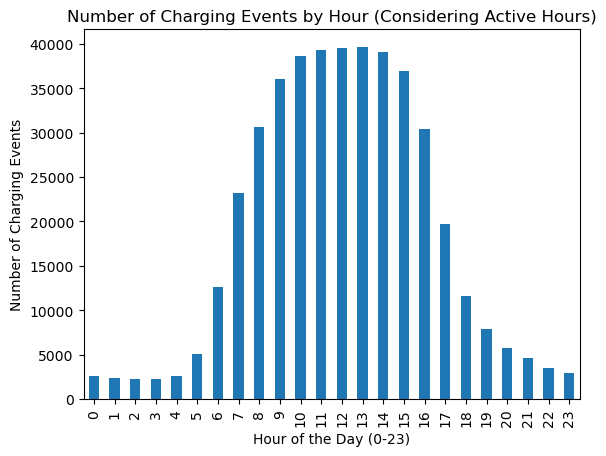

In [12]:
def get_active_hours(row):
    start = row['connectionTime']
    end = row['disconnectTime']
    time_range = pd.date_range(start=start, end=end, freq='H')
    return [time.hour for time in time_range]
df_ev['active_hours'] = df_ev.apply(get_active_hours, axis=1)
all_hours = [hour for hours in df_ev['active_hours'] for hour in hours]
hourly_counts = pd.Series(all_hours).value_counts().sort_index()
hourly_counts.plot(kind='bar')
plt.title('Number of Charging Events by Hour (Considering Active Hours)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Charging Events')
plt.xticks(range(24))
plt.show()

In [21]:
number_of_days = len(set(df_ev['connectionTime'].dt.date))
print(number_of_days)
hourly_avg = Three_years_hourly_counts / number_of_days
hourly_avg = hourly_avg.round().astype(int)

1125


In [22]:
# Round to the nearest integer 
hourly_counts= hourly_avg.reset_index()
hourly_counts.columns = ['Hour', 'Vehicle_charging_Count']
hourly_counts
# By dividing the total number of charging sessions per hour over three years by the number of days
# we can determine the average hourly charging frequency.

,Hour,Vehicle_charging_Count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,2
6,6,7
7,7,10
8,8,7
9,9,6


<BarContainer object of 24 artists>

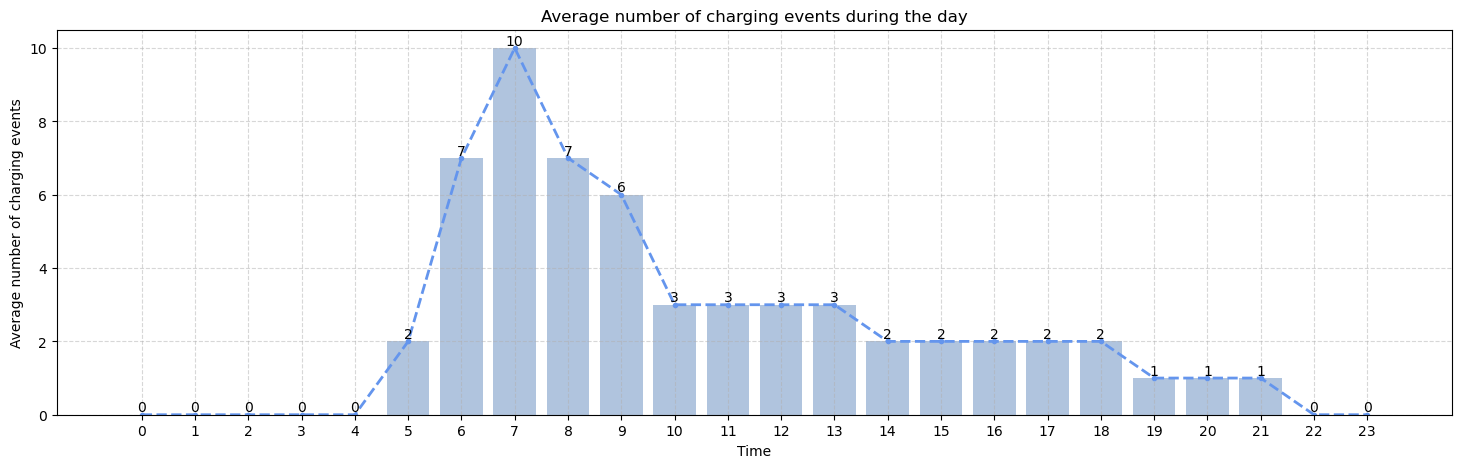

In [23]:
fig=plt.figure(figsize=(18,5))
x=hourly_counts['Hour']
y=hourly_counts['Vehicle_charging_Count']
plt.plot(x, y, color='cornflowerblue',marker='.',linestyle='--',linewidth=2,label='Line Chart')
plt.title('Average number of charging events during the day')
for (a,b) in zip(x,y):
    plt.text(x=a,y=b,s=b,ha='center',va='bottom')
plt.grid(ls="--",alpha=0.5)
plt.xticks(x)
plt.xlabel('Time')
plt.ylabel('Average number of charging events')
plt.bar(x,y,color='lightsteelblue')

### Now weekly calculations

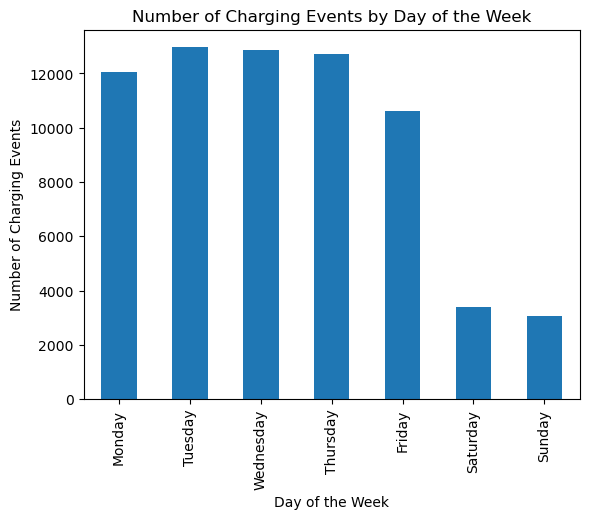

In [14]:
def get_active_weekdays(row):
    start=row['connectionTime'].date()
    end=row['disconnectTime'].date()
    weekday_range=pd.date_range(start=start,end=end,freq='D')
    return [weekday.day_name() for weekday in weekday_range]
df_ev['active_weekday'] = df_ev.apply(get_active_weekdays,axis=1)
all_weekdays=[weekday for weekdays in df_ev['active_weekday'] for weekday in weekdays]
weekly_counts = pd.Series(all_weekdays).value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekly_counts.plot(kind='bar')
plt.title('Number of Charging Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Charging Events')
plt.show()

In [25]:
# the number of weekdays
unique_dates = df_ev['connectionTime'].dt.normalize().unique()
Monday_count =(pd.to_datetime(unique_dates).dayofweek == 0).sum()
print("Number of Mondays:",Monday_count)
Tuesday_count =(pd.to_datetime(unique_dates).dayofweek == 1).sum()
print("Number of Tuesdays:",Tuesday_count)
Wednesday_count =(pd.to_datetime(unique_dates).dayofweek == 2).sum()
print("Number of Wednesdays:",Wednesday_count)
Thursday_count =(pd.to_datetime(unique_dates).dayofweek == 3).sum()
print("Number of Thursdays:",Thursday_count)
Friday_count =(pd.to_datetime(unique_dates).dayofweek == 4).sum()
print("Number of Fridays:",Friday_count)
Saturday_count =(pd.to_datetime(unique_dates).dayofweek == 5).sum()
print("Number of Saturdays:",Saturday_count)
Sunday_count =(pd.to_datetime(unique_dates).dayofweek == 6).sum()
print("Number of Sundays:",Sunday_count)

Number of Mondays: 161
Number of Tuesdays: 160
Number of Wednesdays: 161
Number of Thursdays: 162
Number of Fridays: 162
Number of Saturdays: 160
Number of Sundays: 159


In [26]:
day_counts=pd.Series([Monday_count, Tuesday_count, Wednesday_count, Thursday_count, Friday_count, Saturday_count, Sunday_count],
                     index=['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'])
print(day_counts)

Mon      161
Tues     160
Wed      161
Thurs    162
Fri      162
Sat      160
Sun      159
dtype: int32


In [28]:
weekday = df_ev.groupby(df_ev['connectionTime'].dt.dayofweek).size()
weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekday

Mon      11762
Tues     12585
Wed      12458
Thurs    12268
Fri      10229
Sat       2992
Sun       2698
dtype: int64

In [29]:
average_numbe_of_charging=weekday/day_counts
average_numbe_of_charging=average_numbe_of_charging.round().astype(int)
print(average_numbe_of_charging)

Mon      73
Tues     79
Wed      77
Thurs    76
Fri      63
Sat      19
Sun      17
dtype: int32


In [30]:
Day_counts= average_numbe_of_charging.reset_index()
Day_counts.columns = ['Weekday', 'Vehicle_charging_Counts']
Day_counts

,Weekday,Vehicle_charging_Counts
0,Mon,73
1,Tues,79
2,Wed,77
3,Thurs,76
4,Fri,63
5,Sat,19
6,Sun,17


<BarContainer object of 7 artists>

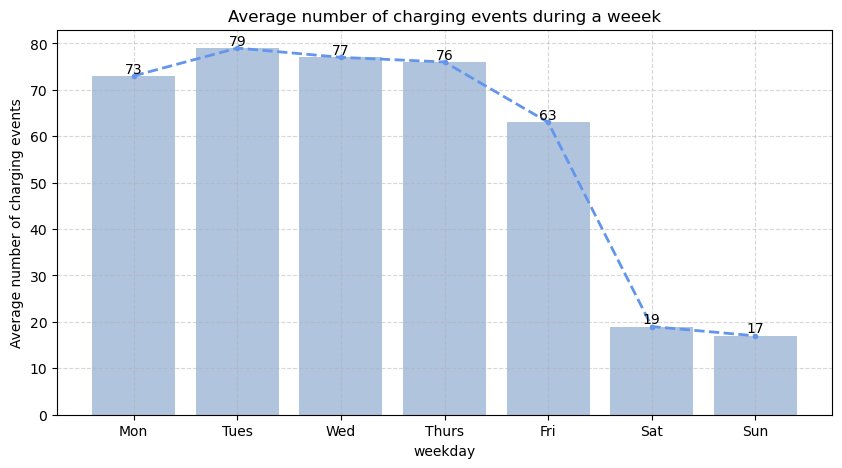

In [31]:
fig=plt.figure(figsize=(10,5))
x=Day_counts['Weekday']
y=Day_counts['Vehicle_charging_Counts']
plt.plot(x, y, color='cornflowerblue',marker='.',linestyle='--',linewidth=2,label='Line Chart')
plt.title('Average number of charging events during a weeek')
for (a,b) in zip(x,y):
    plt.text(x=a,y=b,s=b,ha='center',va='bottom')
plt.grid(ls="--",alpha=0.5)
plt.xticks(ticks=range(len(x)), labels=x)  
plt.xlabel('weekday')
plt.ylabel('Average number of charging events')
plt.bar(x,y,color='lightsteelblue')

### Now monthly/seasonal calculations

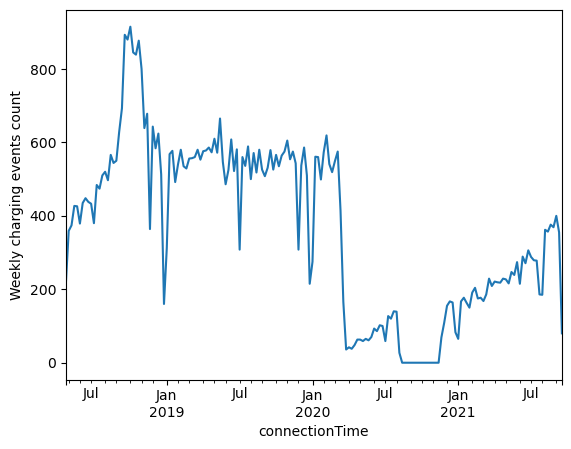

In [38]:
# resample according to week
weekly = df_ev.resample('W').size()
weekly.plot()
plt.ylabel('Weekly charging events count')
plt.rcParams['figure.figsize'] = 15, 5

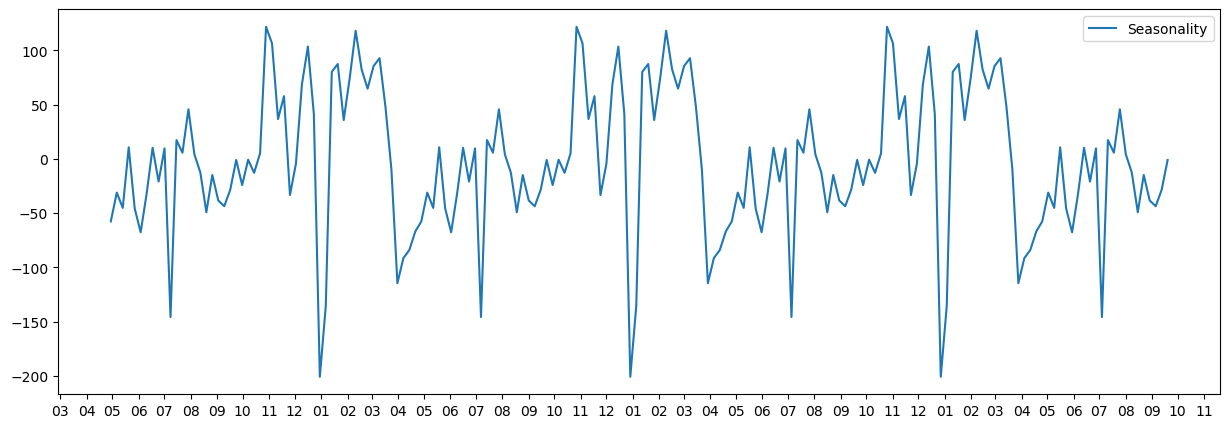

In [41]:
decomposition = seasonal_decompose(weekly)
seasonal = decomposition.seasonal
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%m')) 
ax.xaxis.set_major_locator(MonthLocator())    
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

This graph shows that the number of charging sessions exhibits a regular pattern that repeats annually. In spring, charging demand gradually decreases as the weather warms up and battery performance stabilizes, reducing the need for frequent charging. During summer, charging frequency rises sharply, peaking in July or August due to increased use of air conditioning and cooling equipment driven by higher temperatures. In autumn, charging demand gradually declines again as moderate temperatures improve device efficiency, leading to lower charging needs. In winter, charging demand decreases further, reaching its lowest point in January. This decline is likely due to reduced activity near workplaces and schools during major holidays, such as Christmas, New Year, and winter vacation.

C:\Users\Jan\AppData\Local\Temp\ipykernel_16812\1961520143.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


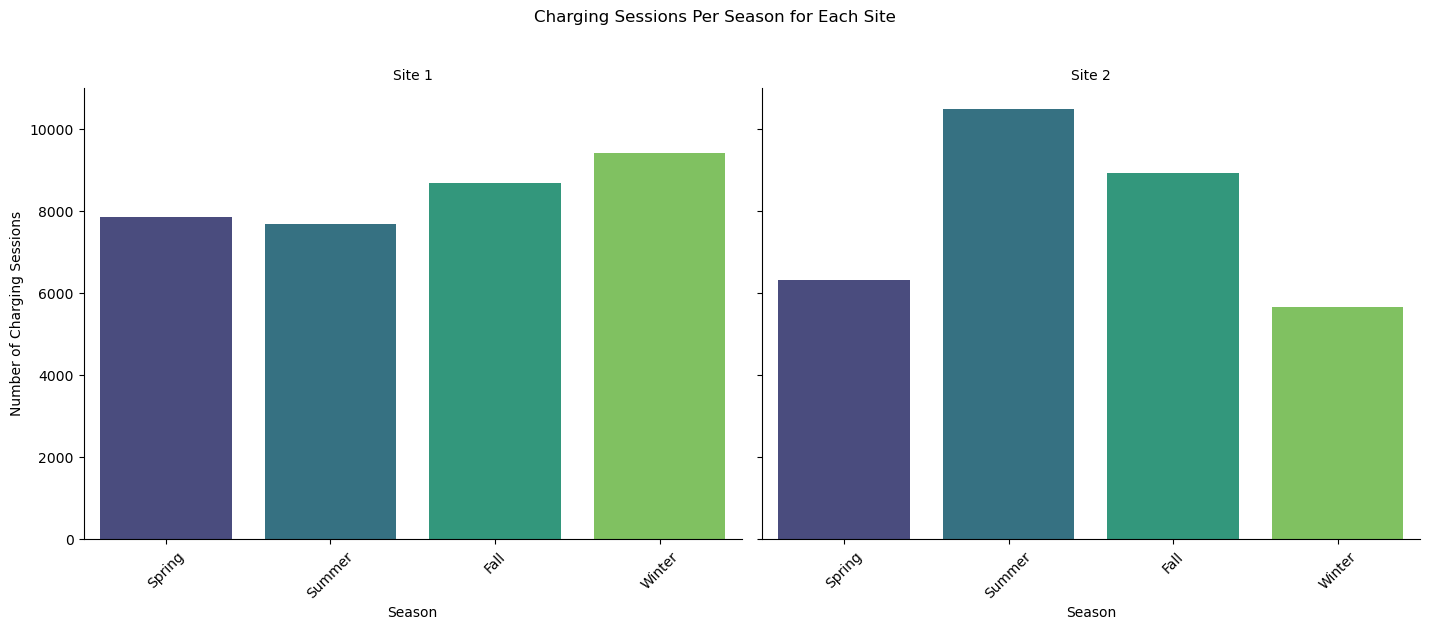

In [16]:
# extract the month
df_ev['month'] = df_ev['connectionTime'].dt.month

# Define the seasons based on months
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df_ev['season'] = df_ev['month'].apply(get_season)

# Define the custom order for seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Group the data by season and site
season_data = df_ev.groupby(['season', 'siteID']).size().reset_index(name='session_count')

# Create a FacetGrid to plot the two sites side by side
g = sns.catplot(
    data=season_data,
    x='season',
    y='session_count',
    col='siteID',
    kind='bar',
    order=season_order,
    height=6,
    aspect=1.2,
    palette='viridis',
    sharey=True  # Ensures both plots have the same y-axis scale
)

# Customize the plot
g.set_titles("Site {col_name}")
g.set_axis_labels("Season", "Number of Charging Sessions")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Charging Sessions Per Season for Each Site")

plt.show()